# Modeling the Practical Efficiency Limits Tandem Solar Cells
## An application to the evaluation of Perovskite-Sililcon tandems

This notebook provides a modeling framework  to quantify the **practical efficiency limits** of perovskite–silicon tandem solar cells, focusing specifically on the impact of **transparent conductive electrodes (TCEs)** on electrical and optical performance.


In [32]:
# libraries # numpy, matplotlib, pandas, scipy, PySpice, gc, time, ctypes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve, least_squares
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import gc
import time

# to be able to use PySpice you  need to install the ngspice library
# and set the NgSpiceShared.library_path to the ngspice.dll file location
# Visit:https://pyspice.fabrice-salvaire.fr/releases/v1.4/overview.html and https://ngspice.sourceforge.io/
# to find out about PySpice and NgSpice installation instructions.

# for ease: visit https://sourceforge.net/projects/ngspice/files/ng-spice-rework/44.2/  
# and download  ngspice-44.2_dll_64.7z
# I include here a link to a pre-compiled ngspice.dll 
# file for Windows, in ./data/ngspice.dll (downloaded July 2025)

from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.NgSpice.Shared import NgSpiceShared

import ctypes
NgSpiceShared.library_path = r'C:\Spice64_dll\dll-vs\ngspice.dll'
ctypes.cdll.LoadLibrary("C:/Spice64_dll/dll-vs/ngspice.dll")

import tandex_func_01 as tandex # this is the main module for TandEx including all background functions

# Constants
k = 1.380649e-23  # Boltzmann constant in J/K
q = 1.60217662e-19  # Electron charge in C
epsrox = 3.9
eps0 = 8.85e-14  # F/cm
epsrs = 11.9
T = 300  # K
Vt = (k * T) / q  # eV
hc = 1240  # eV*nm
c = 3e8  # m/s
Pin = 0.1  # W/cm^2


## The calculation is based on a multi-diode circuit model of the two subcells:
![Circuit Model](./data/circuit2.png)
### We begin by considering the electrical and optical losses from TCEs

TCEs introduce series resistance and shading losses. The power dissipated due to lateral conduction is given by $ dP = I^2 dR $, where $ dR = R^{	ext{TCE}}_{	ext{sheet}} \cdot dx/w $ and $ I = Jwx $. 

Integrated over half the finger pitch $ l $, this yields an effective series resistance of $ R_s = R^{	ext{TCE}}_{	ext{sheet}} \cdot l / 6w $, or in resistivity form, $\rho_s = R^{	ext{TCE}}_{	ext{sheet}} \cdot l^2 / 12 $.

Optical losses are captured via the weighted average transmittance is calculated as :

$ WAT = \frac{ \int T_x(\lambda) \cdot AM1.5G(\lambda) d\lambda }{ \int AM1.5G(\lambda) d\lambda } $.

###  we then define the properties of the two subcells (the parameters for the circuit):

In [33]:
# Parameters #

data = np.load('./data/AM15g_spectrum.npz') # load AM1.5g spectrum
# LambdaVar in nm, and AM15gFlux in s^-1*cm^-2*nm^-1

lambda_vec = np.arange(250, 1400, 5) # vector of wavelengths in nm
AM15g= np.interp(lambda_vec, data['LambdaVar'], data['AM15gFlux'])

# top cell parameters [Lead Halide Perovskite FACsPbIBr]
EgapP = 1.72 # bandgap (eV)
pvk_thick= 650e-7 # cm
Rsh_pvk=200e3 # Shunt resistance in ohms.cm2
J01d_pvk=  7e-24 # A/cm2
J02_pvk=  1.4e-13 # A/cm2
J0def_pvk =  1e-20 # A/cm2
Rdef_pvk = 200 # ohms.cm2

# bottom cell parameters [Silicon]
EgapSi = 1.12 # bandgap (eV)
Rsh_Si=3000e3 # Shunt resistance (ohms.cm2)
Waf_thick=0.01 # cm
Ndop = 5e14  # Doping concentration (cm^-3)
dop_type = -1  # n-type -1, p-type +1
ni = 9.65e9  # Intrinsic carrier concentration (cm^-3)
n_def=1 # ideality factor for SRH recombination
J0n_Si=2e-15 # A/cm2 

C_aug=2.945e-30 # Auger recombination coefficient (cm^6/s)
J0Aug_Si=q*C_aug*ni**3*Waf_thick # A/cm2

# combined series resistance from internal transport factors
RserInt = 1.2 + 0.01 # ohms.cm2 - internal series resistance (pvk + Si).

# Black body spectrum at 300K temperature
BB300K = (2 * np.pi * c / ((lambda_vec * 1e-9) * lambda_vec * (lambda_vec * 1e-7) ** 2)) * \
            (1.0 / (np.exp(hc / (lambda_vec * Vt)) - 1))




In each sub-cell the radiative dark current is given by:

$ J_{01} = q \int BB(\lambda) \cdot EQE(\lambda) d\lambda $,  with $ BB(\lambda) = \frac{2\pi c}{\lambda^4} \cdot \frac{1}{e^{hc/\lambda kT} - 1} $.  

The short-circuit current for the perovskite is:

$ J_{sc,P} = q \int AM1.5G(\lambda) \cdot EQE_P(\lambda)  d\lambda $, 

with $ EQE_P(\lambda) = T_{x,{front}} \cdot (1 - e^{- \alpha(\lambda) W}) $. 

Here, $T_{x,{front}}$ represents the percentage of light transmitted thorugh the front layer stack, comprising the TCE plus any additional layers: ARC, ETL, buffers. W represents the perovskite absorber thickness, and $\alpha$ the absorption coefficient (which should be obtained experimentally).

For silicon, light filtering throught the PVK and Lambertian light trapping from textures lead to a short-cricuti current given by:

 $ J_{sc,Si} = q \int AM1.5G(\lambda) \cdot (1 - EQE_P(\lambda)) \cdot  EQE_{Si}(\lambda) d\lambda $, 
 
 with 

$ EQE_{Si} = T_{x,{mid}} \cdot \frac{1 - \exp(-2Z  \alpha W)}{1 - (1 - 1/n^2) \cdot \exp(-2Z  \alpha W)} $

where $T_{x,{mid}}$ represents the transmission through any layers in the middle, interconnecting the two cells.

The optical pathlength enhancement factor (Z) can be obtained as: $ Z(\lambda) = \frac{2 + a( \alpha W)^b}{1 + a( \alpha W)^b} $. ( a=0.935 and b=0.67 following Green’s model)


*Note*: make sure the ./data/ folder has a .csv file for the optical properties of the Si and PVK absorbers to be used. They will be called by the functions that calculate Jsc.

### we can now calculate tandem efficiency as a function of TCO sheet resistances and transmittances

Maximum Efficiency: 36.66 %
Jsc: 21.60 mA/cm^2, Si Jsc: 21.73 mA/cm^2, Pvk Jsc: 21.88 mA/cm^2
Voc: 2.00 V
FF: 0.85


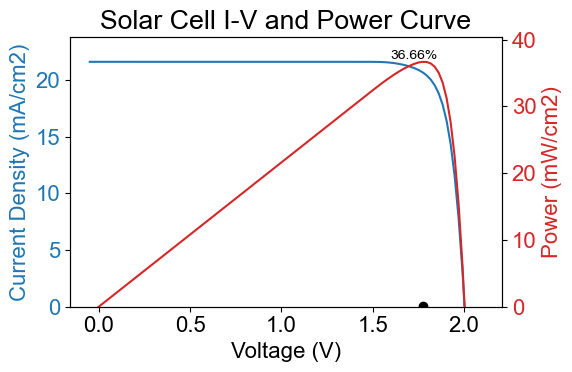

In [34]:
# Simulation #
start = time.time() #can monitor the time taken for the simulation

w = 0.2  # Unit cell dimensions (cm)
l_values = np.linspace(0.02, 0.7, 100)  # range of values to extract optimal pitch l (cm)
d=20e-4 # Contact width in cm
Vcell = np.linspace(-0.05, 2.1, 100) # the voltage range for the cell simulation

R_tco_vec = np.logspace(1, np.log10(3000), 8)  # TCO sheet resistance (ohm/sq)

Tx_vec = np.linspace(0.85, 1, 6)  # TCO transmittance, 85%-100% range

# Initialize arrays
eff_vec = np.zeros([np.size(R_tco_vec), np.size(Tx_vec)])  
Jsc_vec = np.zeros([np.size(R_tco_vec), np.size(Tx_vec)]) 
Voc_vec = np.zeros([np.size(R_tco_vec), np.size(Tx_vec)]) 

# Loop over TCO transmittance values (Tx)
for ind2, Tx in enumerate(Tx_vec):

    # calculate the generation rates, and Jsc based on the TCO transmittance ( A/cm2)
    Jsc_pvk, AM15g_after_pvk, Abs_pvk = tandex.Jsc_pvk_func(lambda_vec, Tx*AM15g, pvk_thick)
    Jsc_Si, AxSi = tandex.Jsc_Si_fun(Waf_thick, lambda_vec, AM15g_after_pvk)

    EQE_pvk= Abs_pvk
    EQE_Si = AM15g_after_pvk * AxSi / AM15g
    
    J0_pvk=q * np.trapezoid(BB300K*EQE_pvk , lambda_vec)
    J0_Si=q * np.trapezoid(BB300K*EQE_Si , lambda_vec)

    # Loop over the TCO sheet resistance values (R_tco)
    for ind1, R_tco in enumerate(R_tco_vec):
            
        AAF = 1 - d / l_values  # Active Area Fraction, assuming d = 20 um contact width
        l, _, _, _, _ = tandex.find_optimal_pitch(J0_Si, J0n_Si, J0Aug_Si, Rsh_Si, Jsc_Si, l_values, R_tco, AAF)
        
        AAF = 1 - d / l  
        
        # Re-calculate the currents, based on the optimal pitch. Units of Amperes
        # perovskite top cell
        Isc_pvk = -AAF * w * (l / 2) *Jsc_pvk
        I0_pvk =  w * (l / 2) * J0_pvk
        I01d_pvk= ( w * (l / 2)) * J01d_pvk
        
        # silicon bottom cell
        Isc_Si = -AAF * w * (l / 2) *Jsc_Si
        I01_Si =  w * (l / 2) * J0_Si
        
        Rser = R_tco * (l**2/ (12)) + RserInt # series resistance in ohms.cm^2 [TCO + external]
     
        # top cell parameters: Isc_pvk, Rsh_pvk, I0_pvk, I0def_pvk, Rdef_pvk, I02_pvk
        top_cell= [Isc_pvk, Rsh_pvk / ( w * (l / 2)), I0_pvk + I01d_pvk,  J0def_pvk * w * (l / 2), Rdef_pvk/ ( w * (l / 2)), J02_pvk* w * (l / 2)]
        # bottom cell parameters: Isc_Si, Rsh_Si, I01_Si, I0Aug_Si, I0d_Si, n_def 
        bottom_cell = [Isc_Si, Rsh_Si/(w*(l/2)), I01_Si, J0Aug_Si* w * (l / 2) , J0n_Si* w * (l / 2), n_def]
        
        voltages, currents = tandex.simulate_circuit(top_cell, bottom_cell, Rser, w, l, Vcell)

        eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, False)
        if ind1 == 0 and ind2 == np.size(Tx_vec)-1:
            print(f"Maximum Efficiency: {eff:.2f} %")
            print(f"Jsc: {Jsc*1e3:.2f} mA/cm^2, Si Jsc: {Jsc_Si*1e3:.2f} mA/cm^2, Pvk Jsc: {Jsc_pvk*1e3:.2f} mA/cm^2")
            print(f"Voc: {Voc:.2f} V")
            print(f"FF: {FF:.2f}")
            eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, True)
            
        eff_vec[ind1, ind2] = eff   
        Jsc_vec[ind1, ind2] = Jsc
        Voc_vec[ind1, ind2]= Voc

    # for long simulation times, uncomment the following lines to print progress
    # end = time.time()
    # print(f"Elapsed time: {end - start:.2f} seconds, ind1={ind1}, ind2={ind2}")


## We can now get a plot of efficiency as a function of R_sh_tce and T_x

<a list of 8 text.Text objects>

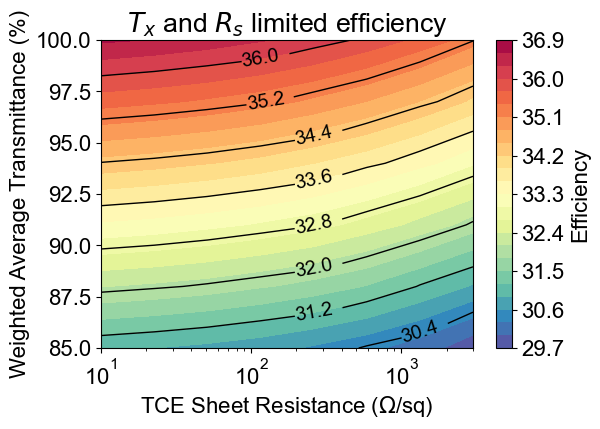

In [35]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
dum = Jsc_vec.max(axis=0) / np.max(Jsc_vec)
plt.figure(figsize=(6, 4))
contour = plt.contourf(R_tco_vec, 100 * Tx_vec, np.transpose(eff_vec), levels=25, cmap='Spectral_r')
cbar = plt.colorbar(contour, label='Efficiency')
plt.xscale('log')
plt.xlabel(r'TCE Sheet Resistance ($\Omega$/sq)')
plt.ylabel(r'Weighted Average Transmittance (%)')
plt.title(r'$T_x$ and $R_s$ limited efficiency')
plt.ylim(85, 100)

# Add contour lines and labels
contour_lines = plt.contour(R_tco_vec, 100 * Tx_vec, np.transpose(eff_vec), levels=8, colors='k', linewidths=1)
plt.clabel(contour_lines, inline=True, fontsize=14, fmt="%.1f")

## The efficiency limit of a perovskite single junction

For evaluating the ultimate limit of a single junction it is best to ignore the loss contributions from the TCEs by assuming no lateral resistance to the metal contact. This is equivalent to having full area metal contacts. We can also ignore any optical losses, assuming all light is coupled into the PVK. 

We can then concentrate on the bandgap and thickness of the absorber, and all the quality parameters (J0 and ideality factors for recombination processes).

To estimate voltage loss in perovskites, we follow Allen's approach, setting the external radiative efficiency as an evaluation of the pervskite cell quality:

$ ERE = \frac{e^{V_{oc}/V_t} \cdot J_{0,{rad}}}{J_{sc}} $.

And we use the knowledge of the best pervoskite cell efficiencies reproted in the literature (for the noted Egap) to find circuit parameters that well reflect the current state of the field, and the possible improvements in perovskite device passivation to reach 10% ERE.

So we first define the pvk parameters:

In [36]:
# top cell parameters [Perovskite]
EgapP = 1.72 # bandgap (eV)d
pvk_thick= 650e-7 # cm
Rsh_pvk=200e3 # Shunt resistance in ohms.cm2
J01d_pvk=  7e-24 # A/cm2
J02_pvk=  1.4e-13 # A/cm2
J0def_pvk =  1e-20 # A/cm2
Rdef_pvk = 200 # ohms.cm2
RserInt = 1.2 # ohms.cm2 - external series resistance.

w = 1  # Unit cell dimensions (cm)
l = 2  #  pitch (cm) (such that the active area is 1 cm^2)

and then calculate the cell efficiency:

Efficiency= 22.93, Jsc = 21.88430 mA/cm^2, Voc = 1.26558 V, FF = 82.78541 % 
J0_pvk = 1.18917e-24 A/cm^2
ERE = 9.91 %


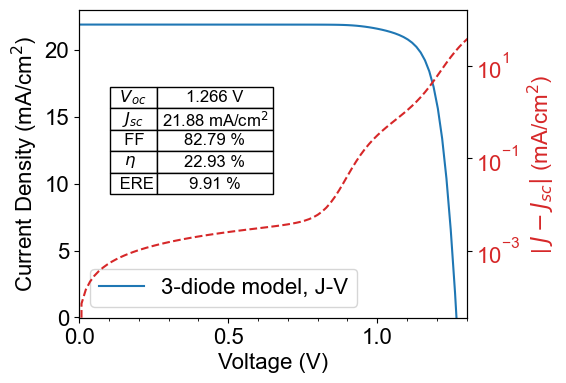

In [37]:
# Perovskite top cell single junction simulation
Vcell = np.linspace(-0.05, (EgapP)*0.8, 100) # the voltage range for the cell simulation

# calculate the generation rates, and Jsc (A/cm2)
Jsc_pvk, AM15g_after_pvk, Abs_pvk = tandex.Jsc_pvk_func(lambda_vec, AM15g, pvk_thick)
J0_pvk=q * np.trapezoid(BB300K*Abs_pvk , lambda_vec)
AAF = 1 # Active Area Fraction

# perovskite top cell currents in Amps
Isc_pvk = -AAF * w * (l / 2) *Jsc_pvk
I0_pvk =  w * (l / 2) * J0_pvk
I01d_pvk= w * (l / 2) * J01d_pvk

Rser = 0 + RserInt # series resistance in ohms.cm^2 [TCO + external]

# top cell parameters: Isc_pvk, Rsh_pvk, I0_pvk, I0def_pvk, Rdef_pvk, I02_pvk
top_cell= [Isc_pvk, Rsh_pvk / ( w * (l / 2)), I0_pvk + I01d_pvk,  J0def_pvk * w * (l / 2), Rdef_pvk/ ( w * (l / 2)), J02_pvk* w * (l / 2)]

voltages, currents = tandex.simulate_pvk_sj(top_cell, Rser, w, l, Vcell)

eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, False)
ERE= np.exp((q * Voc) / (k * T)) * I0_pvk / (Jsc*( w * (l / 2)))
print(f"Efficiency= {eff:.2f}, Jsc = {1e3*Jsc:.5f} mA/cm^2, Voc = {Voc:.5f} V, FF = {0.1*eff/(Voc*Jsc):.5f} % ")
print(f"J0_pvk = {J0_pvk:.5e} A/cm^2")
print(f"ERE = {100*ERE:.2f} %")

# plot the IV curve
tandex.plot_pvk_iv_curve(voltages, currents, eff, Jsc, Voc, FF, ERE)

## The efficiency limit of a silicon single junction

The implied voltage and current densities can be  modelled via the knowledge of intrinsic and extrinsic recombination in silicon:
 
$ iV = \frac{kT}{q} \ln \left( \frac{\Delta n (N + \Delta n)}{n_{i,{eff}}^2} \right) $ and  $ iJ = J_{sc} - \frac{qW\Delta n}{	\tau_{{eff}}} $,  

with $ 	\tau_{{eff}}^{-1} = 	\tau_{{int}}^{-1} + \frac{J_{0s}(N + \Delta n)}{q W n_{i,{eff}}^2 } $.

This allows to define a pseudo J-V curve (https://doi.org/10.1016/j.solmat.2022.111914).

This seciton is dedicated to finding circuit model parameters that reproduce such pseudo J-V plot, for a given value of total surface recombination velocity, as obtained from the J0s parameter.

We also ignore here the losses originating from TCEs.

Begin by defining the silicon circuit model parameters:


In [38]:
# bottom cell parameters [Silicon]
EgapSi = 1.12 # bandgap (eV)
Rsh_Si=3000e3 # Shunt resistance (ohms.cm2)
Waf_thick=0.01 # cm
Ndop = 5e14  # Doping concentration (cm^-3)
dop_type = -1  # n-type -1, p-type +1
ni = 9.65e9  # Intrinsic carrier concentration (cm^-3)
n_def=1 # ideality factor for SRH recombination
J0n_Si=2e-15 # A/cm2 

C_aug=2.945e-30 # Auger recombination coefficient (cm^6/s)
J0Aug_Si=q*C_aug*ni**3*Waf_thick # A/cm2

# combined series resistance from internal factors
RserInt = 0 + 1e-12 # ohms.cm2 - internal series resistance (pvk + Si).

w = 1  # Unit cell dimensions (cm)
l = 2  #  pitch (cm) (such that the active area is 1 cm^2)

### Calculating Silicon Internal Series Resistivity

The internal series resistivity of a silicon sub-cell uses carrier lifetimes, excess carrier densities, and material resistivity.

We begin by defining a range of excess carrier densities, spanning from $10^9$ to $10^{18} cm^{-3}$, to simulate various injection levels. Using a material model (`Si_bulk_lifetime`), we compute the Auger and radiative lifetimes as well as the effective intrinsic carrier concentration $n_{i,\text{eff}}$, all as functions of doping and excess carrier density.

The total effective carrier lifetime $\tau_{\text{eff}}$ is calculated by summing the individual recombination rates:
$$
\tau_{\text{eff}} = \left( \frac{1}{\tau_{\text{Aug}}} + \frac{1}{\tau_{\text{Rad}}} + \frac{J_0 (N + \Delta n)}{q W n_{i,\text{eff}}^2} \right)^{-1}
$$
This includes Auger, radiative, and SRH-like recombination components.

To estimate the carrier density under illumination, we use the steady-state approximation in Voc conditions:
$$
\Delta n = \frac{J_{\text{sc}} \cdot \tau_{\text{eff}}}{q \cdot W}
$$
The value of $\Delta n$ closest to this estimate is selected from the previously defined range to represent the actual operating point.

Next, the resistivity of silicon at this injection level is determined using a doping- and injection-dependent resistivity model (Klassen's mobility as implemented in https://www2.pvlighthouse.com.au/calculators/Mobility%20calculator/Mobility%20calculator.aspx). The internal series resistance of the silicon is given by the average travel distance for carriers (one wafer thickness):
$$
R_{\text{ser,Si}} = \rho_{\text{Si}} \cdot W
$$
This is the internal ohmic loss of the silicon absorber in units of $\Omega \cdot \text{cm}^2$, and is a critical factor in determining the fill factor and overall efficiency of the device.


Silicon Internal Series Resistivity = 2.24e+00 mOhms.cm^2
Pseudo J-V curve results:
Implied Efficiency: 28.9634, Jsc = 43.6143 mA/cm^2,Voc = 750.7249 mV,FF = 88.4585 %
MSE is: 0.417

3-diode Si single junction simulation results:
Efficiency= 28.86, Jsc = 43.61421 mA/cm^2, Voc = 750.75 mV, FF = 88.15016 % 
J0_Si = 2.97042e-16 A/cm^2
J0Aug_Si = 4.24011e-21 A/cm^2


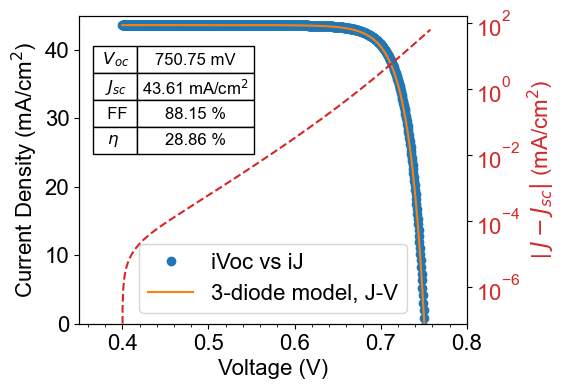

In [39]:
# Silicon bottom cell single junction simulation
Vcell = np.linspace(-0.05, (EgapSi)*0.8, 100) # the voltage range for the cell simulation

# calculate the generation rates, and Jsc ( A/cm2)
Jsc_Si, AxSi = tandex.Jsc_Si_fun(Waf_thick, lambda_vec, AM15g)
J0_Si=q * np.trapezoid(AxSi*BB300K , lambda_vec)
AAF = 1 # Active Area Fraction

# Re-calculate the currents, based on the optimal pitch. Units of Amperes
# silicon bottom cell
Isc_Si = -AAF * w * (l / 2) *Jsc_Si
I01_Si =  w * (l / 2) * J0_Si

delta_n=np.logspace(9, 18, 200) # 
# Calculate  lifetimes
t_Aug, t_Rad, n_i_eff, _, _, _, _ = tandex.Si_bulk_lifetime(dop_type * Ndop, delta_n, Waf_thick, ni, T)
tau_eff = 1 / (1 / t_Aug + 1 / t_Rad + (J0n_Si * (Ndop + delta_n) / (Waf_thick * q * n_i_eff**2)))  # Combined intrinsic lifetime
rhs_Dn=Jsc_Si*tau_eff/(q* Waf_thick)  # Dn diffusion length

delta_n2 = delta_n[np.argmin(np.abs(delta_n - rhs_Dn))]
rho_Si=tandex.Si_res(delta_n2, Ndop)
RserInt= rho_Si * Waf_thick  # ohms.cm^2 - internal series resistance (Si).

Rser = 0 + RserInt[0] # series resistivity in ohms.cm^2 [TCO + external]
print(f"Silicon Internal Series Resistivity = {1e3*RserInt[0]:.2e} mOhms.cm^2")

# bottom cell parameters: Isc_Si, Rsh_Si, I01_Si, I0Aug_Si, I0d_Si, n_def 
bottom_cell = [Isc_Si, Rsh_Si/(w*(l/2)), I01_Si, J0Aug_Si* w * (l / 2) , J0n_Si* w * (l / 2), 1*n_def]

iV, iJ, iJsc, iVoc, iFF = tandex.pseudo_efficiency_Si( l, Waf_thick, J0n_Si, 0, dop_type, Ndop, ni, Jsc_Si)
voltages, currents = tandex.simulate_Si_sj(bottom_cell, Rser, w, l, iV)
eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, False)

print(f"MSE is: {np.sqrt(np.sum( (np.log(np.abs(currents*1e3)) - np.log(np.abs(iJ)))**2)  ):.3f}")

print(f"\n3-diode Si single junction simulation results:")
print(f"Efficiency= {eff:.2f}, Jsc = {1e3*Jsc:.5f} mA/cm^2, Voc = {1e3*Voc:.2f} mV, FF = {0.1*eff/(Voc*Jsc):.5f} % ")
print(f"J0_Si = {J0_Si:.5e} A/cm^2")
print(f"J0Aug_Si = {J0Aug_Si:.5e} A/cm^2")

tandex.plot_si_jv(iV, iJ, voltages, currents, Voc, Jsc, FF, eff)

Maximum Efficiency: 28.92 % for Si wafer thickness 158.62 um


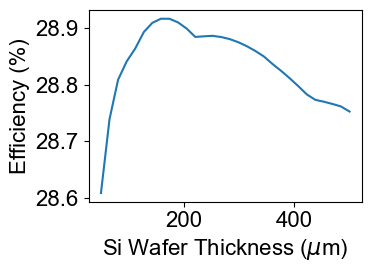

In [40]:
# Calculate Silicon efficiency vs. wafer thickness
Waf_thick_vec = np.linspace(0.005, 0.05, 30)  # 20 points from 20um to 300um

eff_vec = np.zeros_like(Waf_thick_vec)
Voc_vec = np.zeros_like(Waf_thick_vec)
Jsc_vec = np.zeros_like(Waf_thick_vec)

for i, Waf_thick in enumerate(Waf_thick_vec):
    # Update Auger recombination for current thickness
    J0Aug_Si = q * C_aug * ni**3 * Waf_thick

    # Calculate generation rates and Jsc for current thickness
    Jsc_Si, AxSi = tandex.Jsc_Si_fun(Waf_thick, lambda_vec, AM15g)
    J0_Si = q * np.trapezoid(AxSi * BB300K, lambda_vec)

    # Estimate series resistance for current thickness
    t_Aug, t_Rad, n_i_eff, _, _, _, _ = tandex.Si_bulk_lifetime(dop_type * Ndop, delta_n, Waf_thick, ni, T)
    tau_eff = 1 / (1 / t_Aug + 1 / t_Rad + (J0n_Si * (Ndop + delta_n) / (Waf_thick * q * n_i_eff**2)))
    rhs_Dn = Jsc_Si * tau_eff / (q * Waf_thick)
    delta_n2 = delta_n[np.argmin(np.abs(delta_n - rhs_Dn))]
    rho_Si = tandex.Si_res(delta_n2, Ndop)
    RserInt = rho_Si * Waf_thick 
    Rser = RserInt[0]

    # Prepare bottom cell parameters
    Isc_Si = -w * (l / 2) * Jsc_Si
    I01_Si = w * (l / 2) * J0_Si
    bottom_cell = [Isc_Si, Rsh_Si/(w*(l/2)), I01_Si, J0Aug_Si * w * (l / 2), J0n_Si * w * (l / 2), n_def]

    # Simulate JV curve
    Vcell = np.linspace(-0.05, EgapSi * 0.8, 100)
    voltages, currents = tandex.simulate_Si_sj(bottom_cell, Rser, w, l, Vcell)
    eff, Jsc, Voc, FF = tandex.calculate_efficiency(voltages, currents, False)

    eff_vec[i] = eff
    Voc_vec[i] = Voc
    Jsc_vec[i] = Jsc
print(f"Maximum Efficiency: {np.max(eff_vec):.2f} % for Si wafer thickness {Waf_thick_vec[np.argmax(eff_vec)] * 1e4:.2f} um")

# Plot efficiency vs. Si wafer thickness
plt.figure(figsize=(4, 3))
plt.plot(Waf_thick_vec * 1e4, eff_vec, label='Efficiency (%)')
plt.xlabel(r'Si Wafer Thickness ($\mu$m)')
plt.ylabel('Efficiency (%)'); plt.tight_layout(); plt.show()

## Integrated Optical-Electrical Simulation
This uses the Tranfer Matrix Method (TMM) to calculate the full optical solution of a solar cell stack.

TMM algorithm borrowed from: https://web.stanford.edu/group/mcgehee/transfermatrix/index.html, G. F. Burkhard, E. T. Hoke, M. D. McGehee, Adv. Mater., 22, 3293.

Weighted Average Transmittance into the Si: 53.49 %
Weighted Average Absorption in PVK: 39.30 %
Weighted Average Reflection: 5.08 %
Jsc_pvk = 20.55270 mA/cm^2
Jsc_Si = 19.96547 mA/cm^2


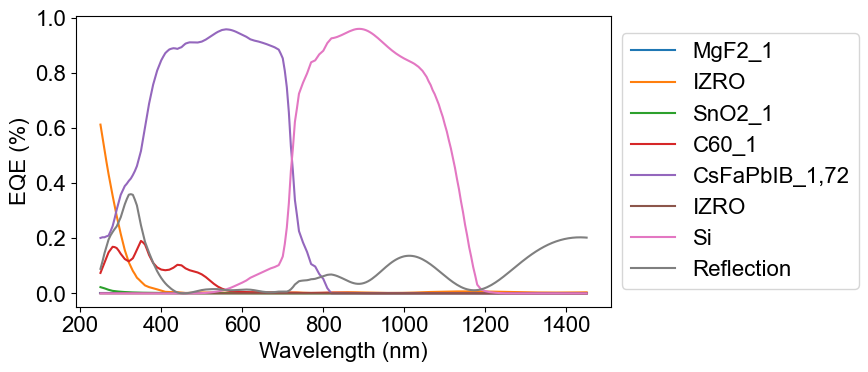

In [41]:
# we begin with the optical simulation of the tandem cell stack
AM15g_spectrum = np.load('./data/AM15g_spectrum.npz') # a numpy file with AM1.5g spectrum

Si_Waf_thick    = 0.01 # cm
pvk_thick       = 650e-7 # cm   
TCE_thick       = 40e-7 # cm 
TCE_rho         = 0.132e-3  # Ω·cm, example value for TCO

layers 			= ['Air' , 'MgF2_1' , 'IZRO' , 'SnO2_1', 'C60_1', 'CsFaPbIB_1,72', 'IZRO', 'Si_' ]
thicknesses		= np.array([0 , 115 , TCE_thick*1e7 , 10 , 10 , pvk_thick*1e7 , 1, 1000 ]) # (nm)
# ignore the Si thickness, 1um only for calculating the Pvk.

pvk_layer_id	= 5			# indexing starts from 0

lambda_start	= 250	# build a wavelength range to calculate over, starting wavelength (nm)
lambda_stop		= 1450	# final wavelength (nm)
lambda_step		= 5	# wavelength step size

x_step=1 # grid spacing of device cross section simulation in nm 

lambda_vec		= np.arange(lambda_start,lambda_stop+lambda_step,lambda_step,float) # wavelength range in nm
AM15g           = np.interp(lambda_vec, AM15g_spectrum['LambdaVar'], AM15g_spectrum['AM15gFlux'])#  nm , s^-1*cm^-2*nm^-1

front_layers    =np.arange(0,7) # layers in front of silicon layer

TotalTx, Absorption, Reflection, E, x_pos, n= tandex.TMM_Tx_Ax(layers, thicknesses, lambda_vec, x_step, front_layers)

WAT= np.dot(AM15g,TotalTx)/np.sum(AM15g)
print(f"Weighted Average Transmittance into the Si: {100*WAT:.2f} %")
print(f"Weighted Average Absorption in PVK: {100*np.sum(AM15g*Absorption[pvk_layer_id,:])/np.sum(AM15g):.2f} %")
print(f"Weighted Average Reflection: {100*np.sum(AM15g*Reflection)/np.sum(AM15g):.2f} %")

Jsc_pvk= q* np.trapezoid(AM15g*Absorption[pvk_layer_id,:], lambda_vec) # A/cm2
print(f"Jsc_pvk = {Jsc_pvk*1e3:.5f} mA/cm^2")

# Plot normalized intensity absorbed / cm3-nm at each layer and wavelength
fig2 = plt.figure(figsize=(9, 4))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('EQE (%)')

# TMM_Tx_Ax returns Absorption as [layer, wavelength], Reflection as [wavelength]
for matind in range(1, len(layers)-1):
    ax2.plot(lambda_vec, Absorption[matind, :], label=layers[matind])

EQE_pvk=Absorption[pvk_layer_id, :]

# Silicon absorption and Jsc are calculated via Green's model for lambertian absorption
FilteredAM15g = AM15g * TotalTx  # Filtered AM15g spectrum after the top cell
Jsc_Si, AxSi = tandex.Jsc_Si_fun(Si_Waf_thick, lambda_vec, FilteredAM15g)
EQE_Si=FilteredAM15g*AxSi/AM15g

print(f"Jsc_Si = {1e3*Jsc_Si:.5f} mA/cm^2")

ax2.plot(lambda_vec, EQE_Si, label='Si')
ax2.plot(lambda_vec, Reflection, label='Reflection')
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, borderaxespad=0)
plt.tight_layout(); plt.show()



Optimal pitch l = 0.241 cm
Maximum Efficiency: 34.00 %
Jsc: 19.80 mA/cm^2
Voc: 2.00 V
FF: 0.86


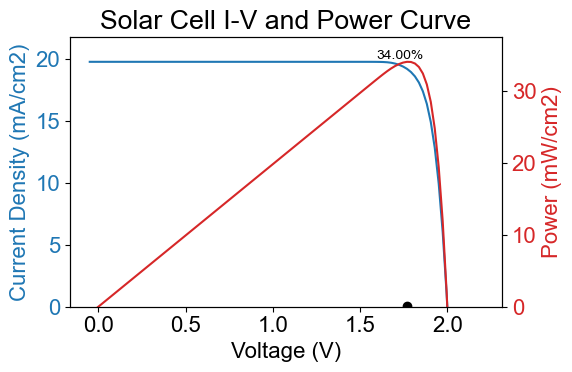

In [42]:
# Electrical simulation

R_tco = TCE_rho / (TCE_thick)  # TCO sheet resistance (Ω/sq) 

# top cell parameters [Lead Halide Perovskite FACsPbIBr]
Rsh_pvk=200e3 # Shunt resistance in ohms.cm2
J01d_pvk=  7e-24 # A/cm2
J02_pvk=  1.4e-13 # A/cm2
J0def_pvk =  1e-20 # A/cm2
Rdef_pvk = 200 # ohms.cm2

# bottom cell parameters [Silicon]
Rsh_Si=3000e3 # Shunt resistance (ohms.cm2)
Ndop = 5e14  # Doping concentration (cm^-3)
dop_type = -1  # n-type -1, p-type +1
ni = 9.65e9  # Intrinsic carrier concentration (cm^-3)
n_def=1 # ideality factor for SRH recombination
J0n_Si=2e-15 # A/cm2 

C_aug=2.945e-30 # Auger recombination coefficient (cm^6/s)
J0Aug_Si=q*C_aug*ni**3*Si_Waf_thick # A/cm2

# combined series resistance from internal factors
RserInt = 1.2 + 0.01 # ohms.cm2 - internal series resistance (pvk + Si).

# Black body spectrum at 300K temperature
BB300K = (2 * np.pi * c / ((lambda_vec * 1e-9) * lambda_vec * (lambda_vec * 1e-7) ** 2)) * \
            (1.0 / (np.exp(hc / (lambda_vec * Vt)) - 1))

w = 0.2  # Unit cell dimensions (cm)
d = 20e-4 # Contact width in cm
l_values = np.linspace(0.02, 0.8, 100)  # range of values to extract optimal pitch l (cm)

Vcell = np.linspace(-0.05, 2.2, 100) # the voltage range for the cell simulation

J0_pvk=q * np.trapezoid(BB300K*EQE_pvk , lambda_vec)
J0_Si=q * np.trapezoid(BB300K*EQE_Si , lambda_vec)

AAF = 1 - d / l_values  # Active Area Fraction, assuming d = 20 um contact width
l, _, _, _, _ = tandex.find_optimal_pitch(J0_Si, J0n_Si, J0Aug_Si, Rsh_Si, Jsc_Si, l_values, R_tco, AAF)
print(f"Optimal pitch l = {l:.3f} cm")
AAF = 1 - d / l  

# Re-calculate the currents, based on the optimal pitch. Units of Amperes
# perovskite top cell
Isc_pvk = -AAF * w * (l / 2) *Jsc_pvk
I0_pvk =  w * (l / 2) * J0_pvk
I01d_pvk= ( w * (l / 2)) * J01d_pvk

# silicon bottom cell
Isc_Si = -AAF * w * (l / 2) *Jsc_Si
I01_Si =  w * (l / 2) * J0_Si

Rser = R_tco * (l**2/ (12)) + RserInt # series resistance in ohms.cm^2 [TCO + external]

# top cell parameters: Isc_pvk, Rsh_pvk, I0_pvk, I0def_pvk, Rdef_pvk, I02_pvk
top_cell= [Isc_pvk, Rsh_pvk / ( w * (l / 2)), I0_pvk + I01d_pvk,  J0def_pvk * w * (l / 2), Rdef_pvk/ ( w * (l / 2)), J02_pvk* w * (l / 2)]
# bottom cell parameters: Isc_Si, Rsh_Si, I01_Si, I0Aug_Si, I0d_Si, n_def 
bottom_cell = [Isc_Si, Rsh_Si/(w*(l/2)), I01_Si, J0Aug_Si* w * (l / 2) , J0n_Si* w * (l / 2), n_def]

voltages, currents = tandex.simulate_circuit(top_cell, bottom_cell, Rser, w, l, Vcell)

eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, False)

print(f"Maximum Efficiency: {eff:.2f} %")
print(f"Jsc: {Jsc*1e3:.2f} mA/cm^2")
print(f"Voc: {Voc:.2f} V")
print(f"FF: {FF:.2f}")
eff, Jsc, Voc, FF =tandex.calculate_efficiency(voltages, currents, True)


## Routine to optimise thicknesses:

Maximum Efficiency: 34.86 % at Si wafer thickness 1000.00 um and pvk thickness 1000.00 nm


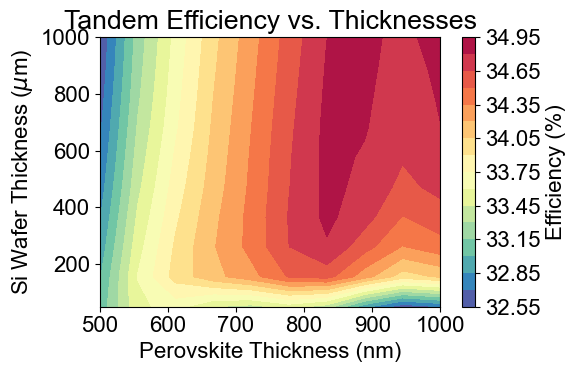

In [ ]:
# Define ranges for Si wafer thickness and perovskite thickness (in cm)
top_cell_density= np.array([Jsc_pvk, Rsh_pvk, J01d_pvk, J0def_pvk, Rdef_pvk, J02_pvk])

Si_waf_thick_vec = np.linspace(0.005, 0.1, 5)      # e.g., 50um to 500um
pvk_thick_vec = np.linspace(500e-7, 1000e-7, 5)     # e.g., 500nm to 1500nm
TCE_thick       = 40e-7 # cm 
TCE_rho         = 0.132e-3  # Ω·cm, example value for TCO
thicknesses		= np.array([0 , 115 , TCE_thick*1e7 , 10 , 10 , pvk_thick*1e7 , 1, 5000 ]) # (nm)

R_tco = TCE_rho / (TCE_thick)  # TCO sheet resistance (Ω/sq) 


eff_map = np.zeros((len(Si_waf_thick_vec), len(pvk_thick_vec)))

for i, Si_waf_thick in enumerate(Si_waf_thick_vec):
    for j, pvk_thick in enumerate(pvk_thick_vec):
        # Update thicknesses array for current pvk and Si thickness
        thicknesses[pvk_layer_id] = pvk_thick * 1e7  # pvk in nm

        # series resistance for current thickness
        t_Aug, t_Rad, n_i_eff, _, _, _, _ = tandex.Si_bulk_lifetime(dop_type * Ndop, delta_n, Si_waf_thick, ni, T)
        tau_eff = 1 / (1 / t_Aug + 1 / t_Rad + (J0n_Si * (Ndop + delta_n) / (Si_waf_thick * q * n_i_eff**2)))
        rhs_Dn = Jsc_Si * tau_eff / (q * Si_waf_thick)
        delta_n2 = delta_n[np.argmin(np.abs(delta_n - rhs_Dn))]
        rho_Si = tandex.Si_res(delta_n2, Ndop)
        RserSi = rho_Si * Si_waf_thick 
        RserInt =  RserSi[0]
        
        # Update bottom cell density parameters for current Si thickness
        J0Aug_Si = q * C_aug * ni**3 * Si_waf_thick
        bottom_cell_density = np.array([Jsc_Si, Rsh_Si, J0_Si, J0Aug_Si, J0n_Si, n_def])

        # Run the optical-electronic efficiency calculation
        eff, *_ = tandex.optic_electronic_efficiency(
            Si_waf_thick, pvk_layer_id, R_tco, BB300K, layers, thicknesses,
            lambda_vec, AM15g, x_step, l_values, front_layers,
            top_cell_density, bottom_cell_density, w, d, voltages, RserInt
        )
        eff_map[i, j] = eff

print(f"Maximum Efficiency: {np.max(eff_map):.2f} % at Si wafer thickness {Si_waf_thick_vec[np.argmax(eff_map) // len(pvk_thick_vec)] * 1e4:.2f} um and pvk thickness {pvk_thick_vec[np.argmax(eff_map) % len(pvk_thick_vec)] * 1e7:.2f} nm")

# Plot the efficiency map
plt.figure(figsize=(6, 4))
X, Y = np.meshgrid(pvk_thick_vec * 1e7, Si_waf_thick_vec * 1e4)  # pvk in nm, Si in um
contour = plt.contourf(X, Y, eff_map, levels=20, cmap='Spectral_r')
cbar = plt.colorbar(contour, label='Efficiency (%)')
plt.xlabel('Perovskite Thickness (nm)')
plt.ylabel(r'Si Wafer Thickness ($\mu$m)')
plt.title('Tandem Efficiency vs. Thicknesses')
plt.tight_layout()
plt.show()

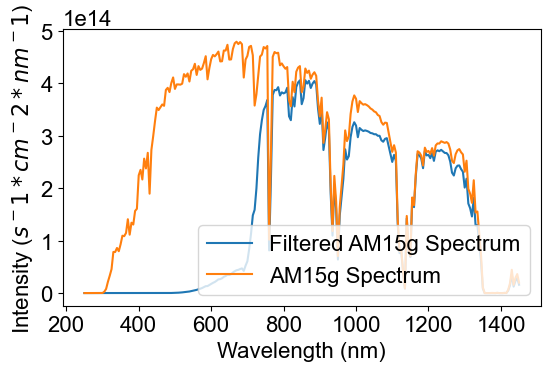

In [44]:
# Plot the filtered AM15g spectrum and the AM15g spectrum

plt.figure(figsize=(6, 4))
plt.plot(lambda_vec, FilteredAM15g, label='Filtered AM15g Spectrum')
plt.plot(lambda_vec, AM15g, label='AM15g Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel(f'Intensity ($s^{-1}*cm^{-2}*nm^{-1}$)')
plt.legend(loc='lower right')
plt.tight_layout()
